intro: 

When looking for a problem that interested us (Naama Shapira 318254240 and Gilad Ilani 307884098), we came to the conclusion that lane detection is something that interests us both. We went through several possibilities for this problem, with several different ideas on how to process the data, how to manipulate it and what information we can get from it. After a lot of deliberation we ultimately decided to go with the DET data set.
According to https://paperswithcode.com/sota/lane-detection-on-det, this dataset hasn't been used by any research except for the one how created and made first paper upon it.
We thought that with the advancement that accrued over the years, and with the fact that no one made any progress with this data since it was originals posted, that we can make feather progress with it. 
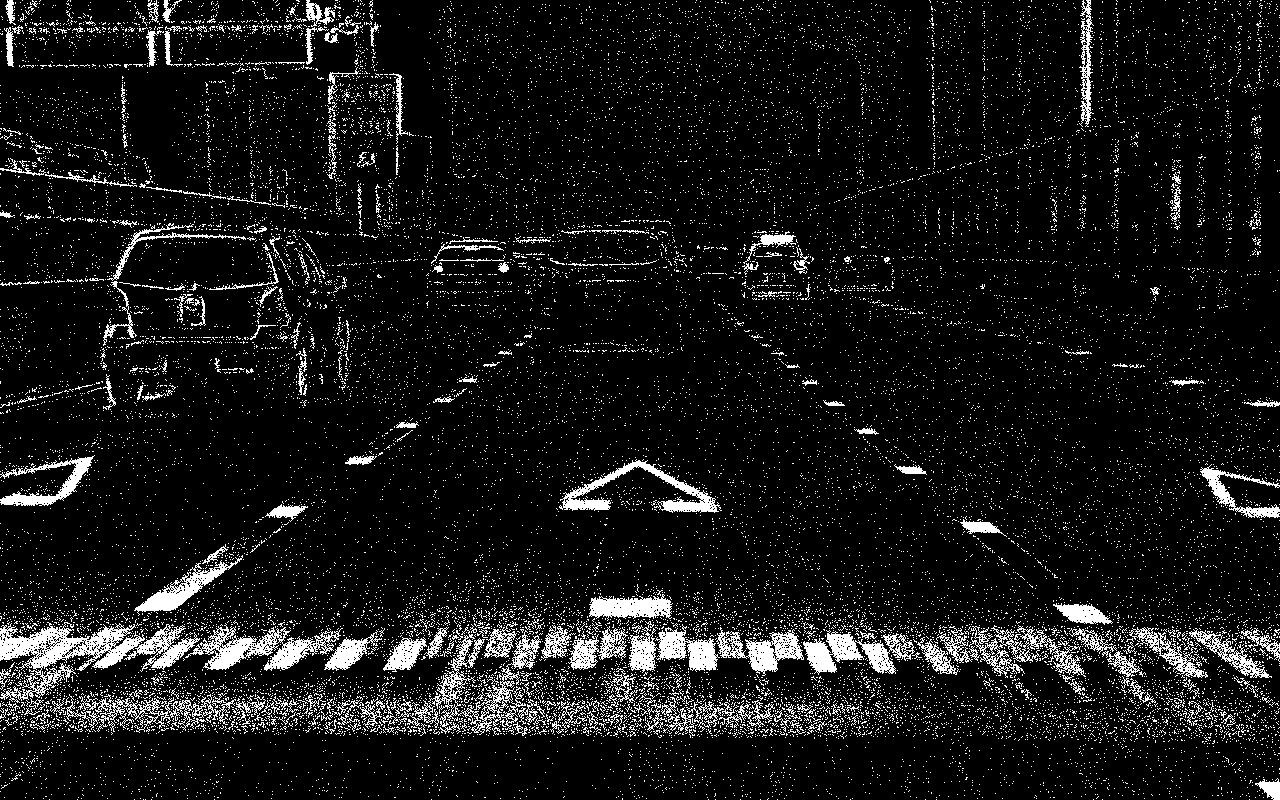

What is the problem:

Autonomous Vehicles are not a dream but a living fact. It will bring not only a great advance in global economy and life spend, but also an enormous leap in engineering in general and computer science in particular. Behind it's general idea relay countless problems which waiting to be solved, of already been solved: Object detecting, environment prediction, agent decision making and much more. We have decided to contributing to the solution of the lane detection problem. Altho we know of a lot of industry companies which has common solution to that problem, it is still considered as half-baked solution: most of the known models are failing in some edge cases and aren't dealing well with test datasets.

About the data  - and why DVS:

DET dataset is a sires of 'photos' taken from a front camera of a moving car driving mostly on highways in the country of China.
We write 'photos' because it is not actually output of a camera but a senor called Dynamic Vision Sensor (DVS). It is an event-based sensor to lane which measure the changes in each pixar in 'light' it if it changed.
This simple process (we presented it simply, there are a few more things happens under the hood) is a great contributor to the lane dictation specificity and autonomous vehicles generally from a few reasons:

High frequency samples - DVS has can make much more samples in a given time, causing the data fed to the agent be much more updated.
Light and reflection resistance - most cameras which are used in current vehicles are reflected by the amount of light inserted to their sensor, when DVS is reflected from the change of the light. so a reflection from a window or a bright light from a crossing car can hurt the camera's ability to  get any info from the environment, while DVS will not.
Light data - since DVS output siriases of ones and zeros, each photo is much smaller in memory then a 3 dimensions, 255 colors image taken from regular photo, causing the whole calculation process to be much faster and lighter.

Example on an image taken using DVS:
<div>
<img src="attachment:image_2022-06-11_162001949.png" width="400"/>
</div>

How we approtched the problem:

We started by cleaning out the noise in each image. We built an algorithm to go through every pixel, and if its not close enough to white, we turned it balck, and if it is, turned it white. The next thing we did was to clean all the single white pixels, that were not a part of a group. That we did with an algorithm that checks the anount of white neighbors each pixel has, then detremning if the pixel stays white (has white neighbors) or turns black (is alone). Then we realized that we only want to have the lanes in our picture, and to we desided to make a triangle that will contain the lanes, and erase everything that is outside of it.

Example of an images we cleaned:

Noise-
<div>
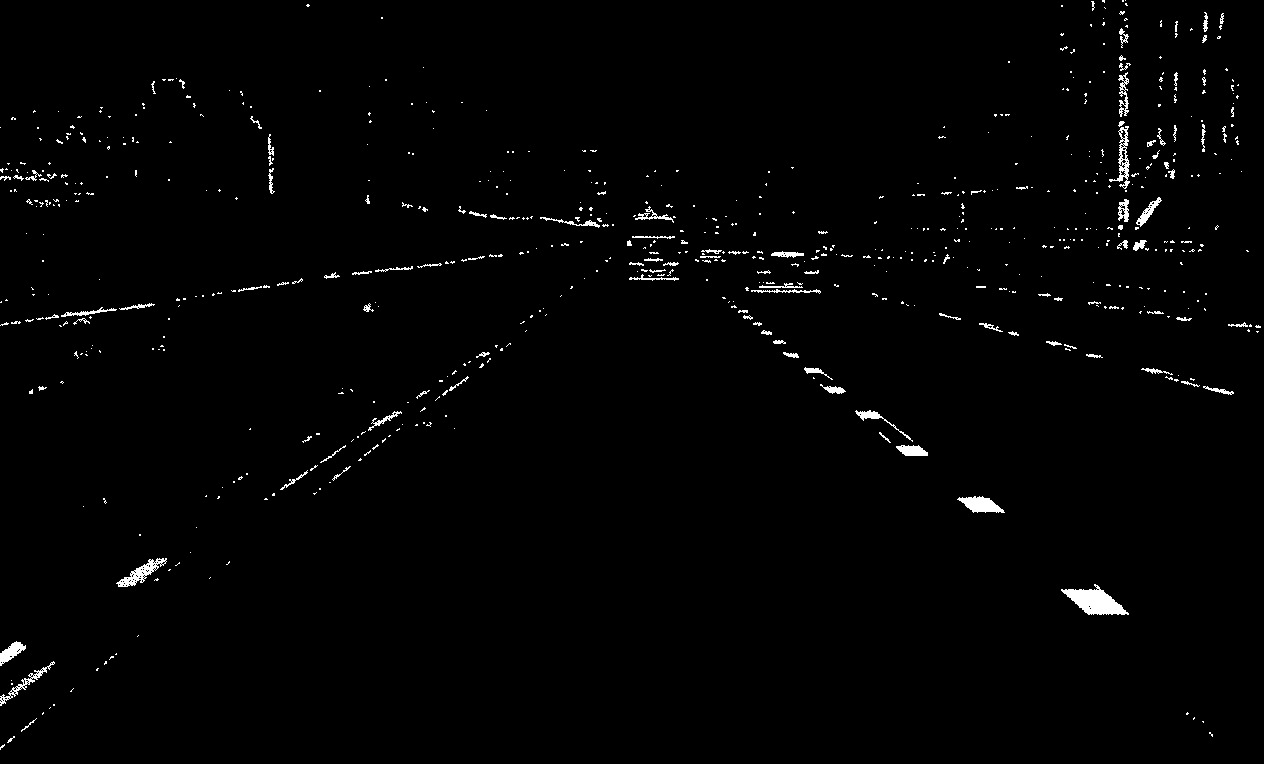
</div>

Tirangle-

<div>
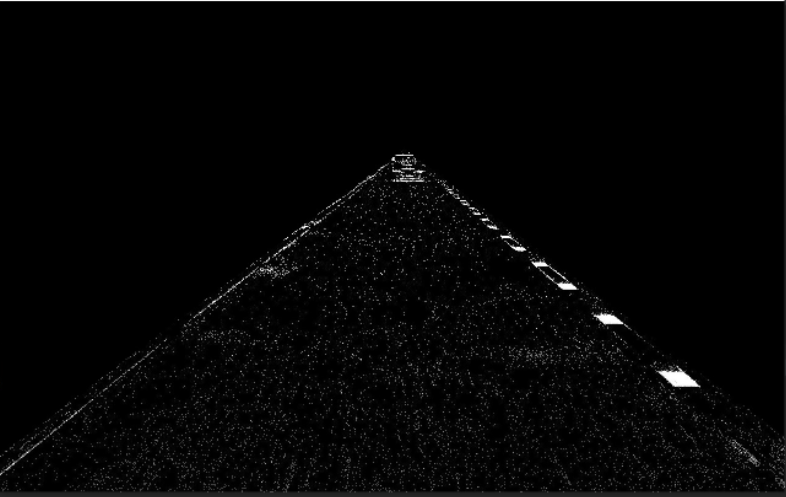
</div>

We then procceded to find ways with which to find the lane. We noticed that there are a few obstrals that we needed to overcome in order to find the right lane. 
The obsticals that we came across were-
    1. Lanes that curv.
    2. Lanes that have things written on them or lines going across them.
    3. dealing with diffret road types, like stright lines.
    
Example images-
Curv-
<div>
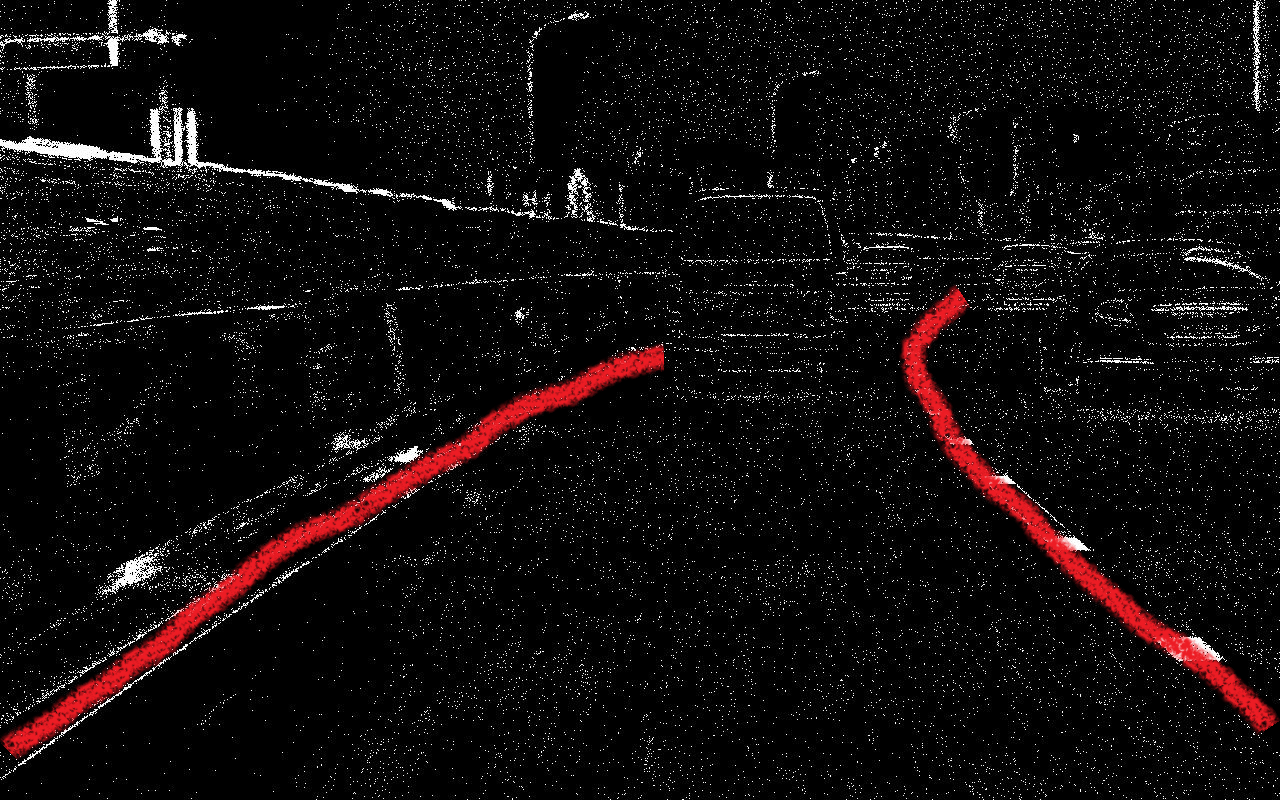
</div>

Words on road-


<div>
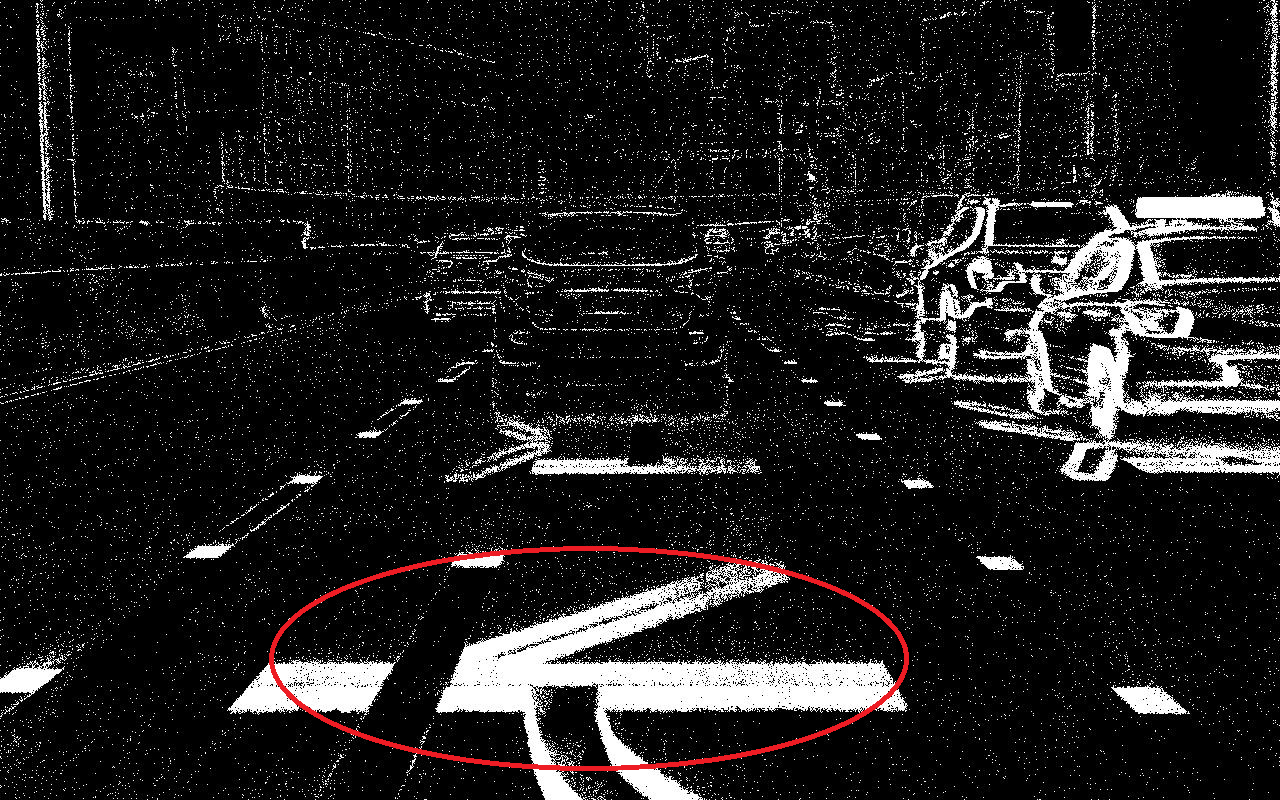
</div>

Line across road-

<div>
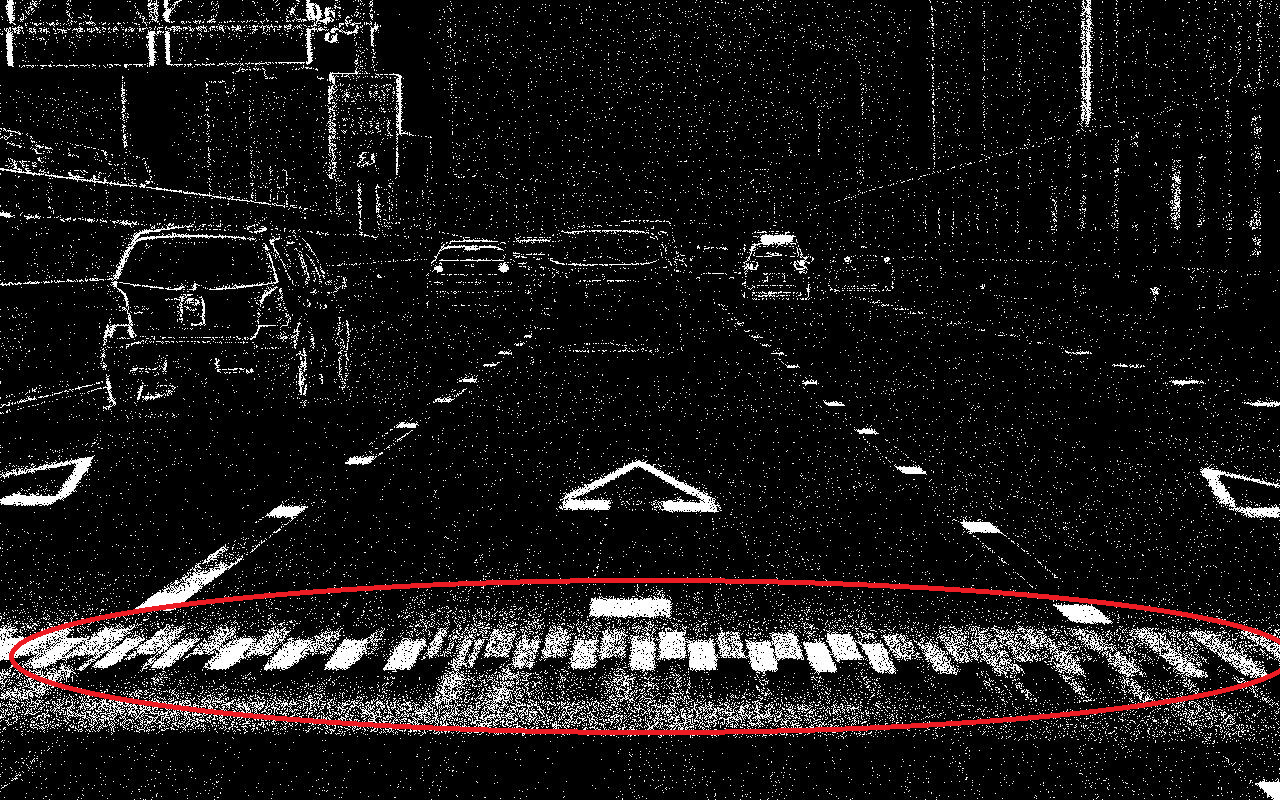
</div>

Diffrent road type-

<div>
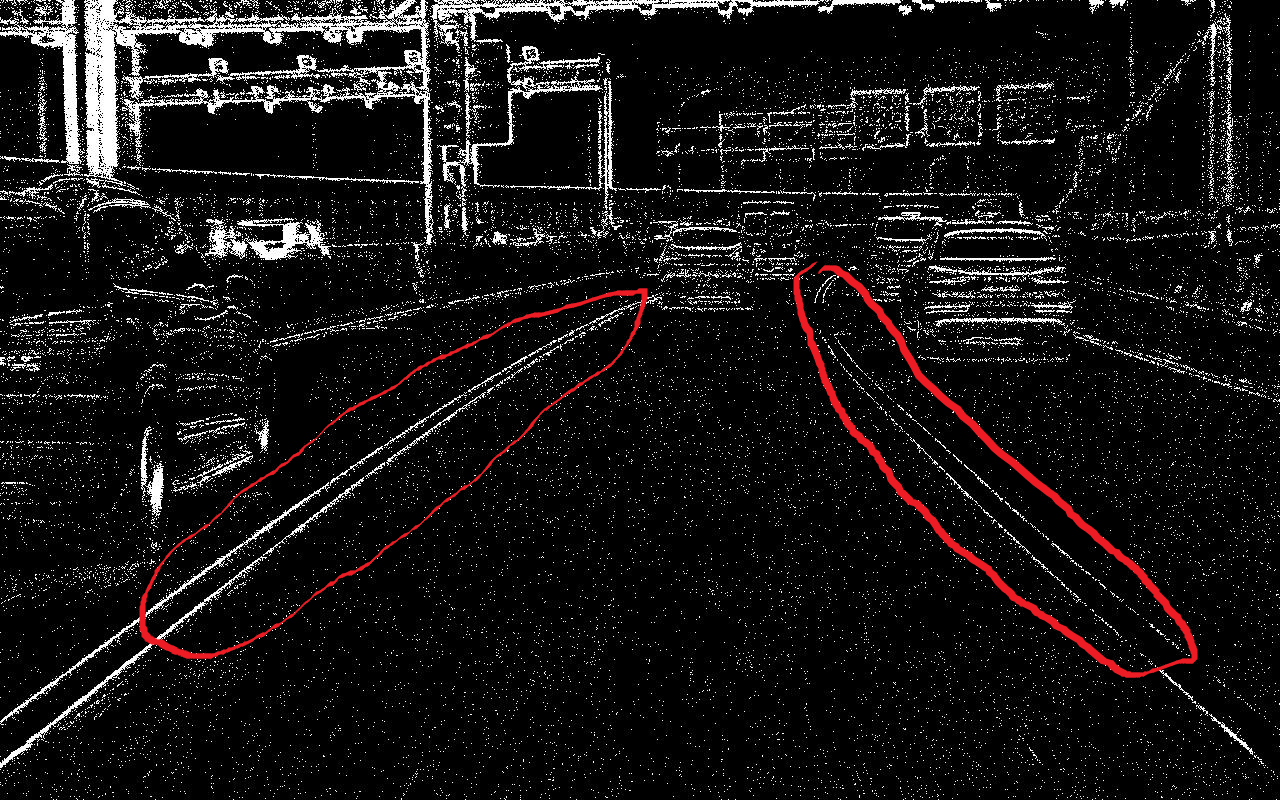
</div>


We thought of many diffrent solutions for our problem, and eventually desided to try and find pixels that represnt the lane and use them in order to find a function to represant the lane.

The way with which we found the pixels is as such- we noticed that the lane starts a the sides of the image, and so we started with a trapezoid that will contain a part of the side of the image. In that trapezoid we found the pixel at the top of the trapezoid that is part of the lane. In order to achive this we used regression on the space insice the trapezoid untill eventually we fount the right point.
The next thing we did was to extaned the next shape, this time being a parallelogram, having the middle of its base be the pixel we found before. Now in order to find the next point we did the same as the start, and so we continued untill we had a group of points that represent the lane.

Using this mathod, we can see that we overcome some of the struggles that we had before, such as being signs at the middle of the road (by starting at the sides) and curvs (fount points to represnt the lane).

After finding the points the last thing we had to do was find the function, or the graph, the goes through all the points. The next thing to do was plot the lanes atop the existing image.
This is how we found the lane in any existiong image.

EDA:

below are to codes we used to clean the images-

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform._hough_transform import circle_perimeter
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from typing import List
import cv2
from cv2 import imshow, waitKey, destroyAllWindows
from cv2 import mean
from typing import Tuple


Point = Tuple[int,int]
Parallelogram = Tuple[Point,Point,int,int]

In [7]:
def linear_equation(base_point, mid_point):
    base_x, base_y = base_point
    x_middle_point, y_middle_point, = mid_point
    m = (y_middle_point - base_y) / (x_middle_point - base_x)
    n = - (m * x_middle_point - y_middle_point)
    return lambda x: m * x + n


def set_triangle_scope(img, mid_point=(640, 200), base_height=650):
    height, width = img.shape
    left_linear_equation = linear_equation((0, base_height), mid_point)
    right_linear_equation = linear_equation((width, base_height), mid_point)
    for i in range(height):
        for j in range(width):
            if left_linear_equation(j) > i or right_linear_equation(j) > i:
                img[i, j] = 0
    return img


def delete_right_half(img):
    height, width = img.shape
    return img[:, :int(width / 2)]


In some of the our first ideas, we noticed that for lanes that go stright, we can see that it can be confined in a triangle were two sides are the lanes and the third is the bottom of the image. So in order to have just the data we needed we desided to find said triangle for the each lane and then clear all the data that is not in the triangle, so we are left with the lane it self. All the data not relating to the road in quastion was deleted.
In order to do so, we first created a function to represent linear equation, and we used this function to represet the lanes (or the sides of the triangle). Then every point that was not in the triangle (above it)) we turned to black.
Eventual we droped this idea...


In [8]:

def general(image_name:str, min_neighbors_amount_list = [2, 1])->np.ndarray:
    img = imread(image_name)
    img = cvtColor(img, COLOR_BGR2GRAY)
    img = delete_none_binary_pixels(img)
    for min_neighbor in min_neighbors_amount_list:
        img = delete_noise_by_neighbors(img, min_neighbors_amount=min_neighbor)
    return img


def delete_noise_by_neighbors(img:np.ndarray, kernel=[-1, 0, 1], min_neighbors_amount=3):
    height, width = img.shape
    out_img = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                continue
            counter = 0
            for k in kernel:
                for m in kernel:
                    try:
                        if img[i + k, j + m] == 255:
                            counter += 1
                    except IndexError:
                        # kernel out of picture bound
                        pass
            # -1 ==> don't count a pixel as its own neighbor!
            if counter - 1 > min_neighbors_amount:
                out_img[i, j] = 255

    return out_img


def delete_none_binary_pixels(img:np.ndarray):
    threshold = 240
    height, width = img.shape

    for i in range(height):
        for j in range(width):
            if img[i, j] > threshold:
                img[i, j] = 255
            else:
                img[i, j] = 0

    return img


def image_to_data(img:np.ndarray):
    points = []
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                continue
            else:
                points.append((j, i))

    return points




As can see from the code above, we used diffrent methods if cleaning the images, that in order to get only the information that we need. Like we explained above, we clean the image we the following methods-
    1. To clean the image from non binary pixels, we went through and checked every pixel. If the pixel was not close enough to white (passed the thrashhold) then we turned it black, and if it was close enough we turned it fully white.
    2.The next step was to clean the noise from the image. In order to do so, we calculated the amount of white neighbors each pixel had,if it passed the minimum amount then the pixel stayes white, otherwhise we turn it black.
    

In [9]:


def set_linear_equation(point_1, point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2
    m = (y_2 - y_1)/(x_2 - x_1)
    n = y_1 - m*x_1
    return lambda x: m * x + n

"""
Get n and m for linear equation out of two points on it's line.
"""
def get_params_for_linear_equation(point_1:Point, point_2:Point)->Point:
    x_1, y_1 = point_1
    x_2, y_2 = point_2

    m = (y_2 - y_1)/(x_2 - x_1)   
    n = y_1 - m*x_1
    return  m , n


def get_data_from_parallelogram(img:np.ndarray, par:Parallelogram):
    upper_left, bottom_right, par_width = par
    x_up_left, y_up = upper_left
    x_btm_right, y_btm = bottom_right

    x_up_right = x_up_left + par_width
    x_btm_left = x_btm_right - par_width

    left_line = set_linear_equation(upper_left, (x_btm_left, y_btm))
    right_line = set_linear_equation(bottom_right, (x_up_right, y_up))
    points = []

    for y in range(y_up, y_btm):
        for x in range(min(x_btm_left,x_up_left),max(x_btm_right,x_up_right) ):
            if img[y, x] == 0:
                continue
            else:
                if min(left_line(x),right_line(x)) <= y <= max(left_line(x),right_line(x)):
                    points.append((x, y))

    return points




Here we want to get the information only found inside the parallelogram, that is so we can use that information in our regration.
We first create linear equations to set the sides of the parallelogram and then only take the data, limiting it to be inside the equeitions.


In [10]:
def all_hough_circle_transform(img):
    img = delete_none_binary_pixels(img)
    img = delete_noise_by_neighbors(img, min_neighbors_amount=2)

    img_unit8 = np.uint8(img)
    radius = np.arange(450, 500)
    h_space = hough_circle(img_unit8, radius)
    accum, cx, cy, rad = hough_circle_peaks(h_space, radius)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    counter = 0
    for center_y, center_x, radius in zip(cy, cx, rad):
        if counter == 100:
            break
        counter += 1
        circ_y, circ_x = circle_perimeter(center_y, center_x, radius, shape=img.shape)
        img[circ_y, circ_x] = 225

    ax.imshow(img, cmap=plt.cm.gray)
    plt.show()


def all_hough_lines_transform(img):
    img = delete_none_binary_pixels(img)
    img = delete_noise_by_neighbors(img, min_neighbors_amount=2)

    img_unit8 = np.uint8(img)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
    h_space, theta, dist = hough_line(img_unit8, tested_angles)
    angle_list = []
    fig, axes = plt.subplots(1, 1)

    axes.imshow(np.log(1 + h_space), aspect=0.05)
    plt.show()
    fig, axes = plt.subplots(1, 1)
    axes.imshow(img, cmap='gray')

    origin = np.array((0, img.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(h_space, theta, dist)):
        angle_list.append(angle)
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        axes.plot(origin, (y0, y1), '-r')
    axes.set_xlim(origin)
    axes.set_ylim((img.shape[0], 0))
    axes.set_axis_off()
    axes.set_title('Detected lines')

    plt.show()


def hough_line_transform(img):
    img = delete_none_binary_pixels(img)
    img = delete_noise_by_neighbors(img, min_neighbors_amount=2)

    img_unit8 = np.uint8(img)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
    h_space, theta, dist = hough_line(img_unit8, tested_angles)
    angle_list = []
    fig, axes = plt.subplots(1, 1)

    axes.imshow(np.log(1 + h_space), aspect=0.05)
    plt.show()
    fig, axes = plt.subplots(1, 1)
    axes.imshow(img, cmap='gray')

    origin = np.array((0, img.shape[1]))
    min_angels = [(9999, 0), (-9999, 0)]
    for _, angle, dist in zip(*hough_line_peaks(h_space, theta, dist)):
        if abs(angle) < 0.1:
            continue

        if 0 < angle < min_angels[0][0]:
            min_angels[0] = (angle, dist)
        elif min_angels[1][0] < angle < 0 and abs(abs(min_angels[0][0]) - abs(angle)) > 0.1:
            min_angels[1] = (angle, dist)

    for angle, dist in min_angels:
        angle_list.append(angle)
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        axes.plot(origin, (y0, y1), '-r')
    axes.set_xlim(origin)
    axes.set_ylim((img.shape[0], 0))
    axes.set_axis_off()
    axes.set_title('Min detected lines')

    plt.show()

In [ ]:
def get_rectangle_from_mid_bottom(mid_bottom_point, length, height, img_width):
    x, y = mid_bottom_point
    if 2 * x < length:
        x = length / 2
    elif 2 * x + length > 2 * img_width:
        x = img_width - length / 2 - 1
    return (int(x - length / 2), int(y - height)), (int(x + length / 2), y)


def draw_parallelogram(img:np.ndarray, par:Parallelogram):
    height, width = img.shape
    upper_left, bottom_right, par_width = par
    x_up_left, y_up = upper_left
    x_btm_right, y_btm = bottom_right

    x_up_right = x_up_left + par_width
    x_btm_left = x_btm_right - par_width

    for coordinate in [x_up_left, x_up_right, x_btm_right, x_btm_left]:
        if coordinate is width or coordinate < 0:
            print ('coordinate is width:' + str(coordinate is width )+ ' width or coordinate < 0:' + str(width or coordinate < 0))
            raise Exception("parallelogram  out of bound")

    for coordinate in [y_up, y_btm]:
        if coordinate is height or coordinate < 0:
            print('coordinate is height:' + str(coordinate is height)+'height or coordinate < 0:' + str(height or coordinate < 0))
            raise Exception("parallelogram out of bound")

    cv2.line(img, upper_left, (x_up_right, y_up), 255, 1)
    cv2.line(img, upper_left, (x_btm_left, y_btm), 255, 1)

    cv2.line(img, bottom_right, (x_up_right, y_up), 255, 1)
    cv2.line(img, bottom_right, (x_btm_left, y_btm), 255, 1)


def draw_rectangle(img, rectangle):
    height, width = img.shape
    upper_left, bottom_right = rectangle
    x_left, y_left = upper_left
    x_right, y_right = bottom_right

    for coordinate in [x_left, x_right]:
        if coordinate is width or coordinate < 0:
            raise Exception("rectangle out of bound")

    for coordinate in [y_left, y_right]:
        if coordinate is height or coordinate < 0:
            raise Exception("rectangle out of bound")

    if x_left > x_right or y_left > y_right:
        raise Exception("rectangle is misplaced")

    img[y_right, x_left:x_right] = 255
    img[y_left, x_left:x_right] = 255

    img[y_left:y_right, x_left] = 255
    img[y_left:y_right, x_right] = 255


def show_image(img:np.ndarray, img_name='img'):
    imshow(img_name, img)
    waitKey(0)
    destroyAllWindows()


def plot_data(points: List[Point]):
    x, y = zip(*points)
    plt.scatter(x, y, s=0.5, c='k')

    ax = plt.gca()  # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.xaxis.tick_top()  # and move the X-Axis
    plt.show()

def draw_line_from_RANSAC(img, linear_equation_by_x):
    xy = [(i, int(linear_equation_by_x(i)))
          for i in range(600) if 0 < int(linear_equation_by_x(i)) < 800]

    max: tuple
    min: tuple
    min_y = 9999
    max_y = -1
    for point in xy:
        x, y = point
        if y < min_y:
            min = point
            min_y = y
        if y > max_y:
            max = point
            max_y = y

    cv2.line(img, min, max, 255, 1)
    show_image(img)

In [11]:

def find_func(points_l,points_r, image):
    x_l = []
    y_l = []
    x_r = []
    y_r = []
    for p in points_l:
        x_l.append(p[0])
        y_l.append(p[1])
    for p in points_r:
        x_r.append(p[0])
        y_r.append(p[1])
    middle =(min(x_r) + max(x_l))/2
    name = image + '.jpg'
    func_l = np.polyfit(x_l, y_l, 2)
    fx_l = np.linspace(0,middle, 800)
    fy_l = np.polyval(func_l, fx_l)
    func_r = np.polyfit(x_r, y_r, 2)
    fx_r = np.linspace(middle , 1280, 800)
    fy_r = np.polyval(func_r, fx_r)
    im = plt.imread(name)
    fig, ax = plt.subplots()
    ax.imshow(im, extent=[0, 1280, 0, 800])
    ax.plot(fx_l, fy_l, '-', color='red')
    ax.plot(fx_r, fy_r, '-', color='green')
    plt.show()

And lastly, after finding the points of the lanes, we found the curv that goes through them. This curv represents the lane, and after finding both curvs, one for each side of the lane, we added them on to the image.